In [19]:
%%time
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import pandas as pd
import numpy as np
import scipy.io.wavfile
from scipy import fftpack

import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

from os import sep
from os.path import isfile, join, abspath
from moviepy.editor import AudioFileClip, VideoFileClip, concatenate_videoclips, concatenate_audioclips

from sklearn.decomposition import PCA
from ggplot import *

Wall time: 1e+03 µs


In [3]:
dirpath = join(abspath(sep),'temp')
file_basename = 'trainingData'
eventFileName = join('.', file_basename+'.csv')
event_data = pd.read_csv(eventFileName, sep=',',header=0)

In [4]:
# Compute offset of each clip in the new clips collection and add to DataFrame
offset=np.cumsum(event_data["timeToCapture"])
event_data["offset"]=offset-event_data["timeToCapture"]
# Prepare a list of labels
labels=[row["eventName"] 
        for index,row in event_data.iterrows() 
        for i in np.arange(row["offset"],row["offset"]+row["timeToCapture"])]

# Concatenate video clips using ffmpeg (fast but audio gets out of sync)
This approach needs more work. In the mean time use the slower videoPy option below

In [ ]:
#for index, row in event_data.iterrows():
#    #print row['secondOffset'], row['timeToCapture']
#    if row['fileName'] == file_basename+'.wav':
#        outFileName=os.path.join(dirpath, file_basename+str(index)+'.mp4')
#        print 'Writing clip #',index,' from sec ',row['secondOffset'],' length ',row['timeToCapture']
#        ffmpeg_extract_subclip(videoFileName, row['secondOffset'], row['secondOffset']+row['timeToCapture'], targetname=outFileName)
#    else:
#        print 'Skipping ', row['fileName']

# https://trac.ffmpeg.org/wiki/Concatenate
Getting error: "IOPub data rate exceeded"?

Add the following as a parameter to 'Jupyter notebook': --NotebookApp.iopub_data_rate_limit=50000000
or upgrade Jupyter notebook to 5.1

# Concatenate video clips using videoPy


In [ ]:
%%time
clips=[]
for index, row in event_data.iterrows():
    #print row['secondOffset'], row['timeToCapture']
    videoFileName = join(dirpath, row['fileName'])
    if isfile(videoFileName):
        videoClip = VideoFileClip(videoFileName).subclip(row['secondOffset'],row['secondOffset']+row['timeToCapture'])
        clips.append(videoClip)
    else:
        print 'Could not find file ', videoFileName

final_clip = concatenate_videoclips(clips)
final_clip.write_videofile(join(dirpath, "my_concatenation.mp4"))


# Play a video clip

In [ ]:
# Utility: Play a video clip from file starting at <offset> (in seconds) for <length> (in seconds)
def getClip(path=join(dirpath, "my_concatenation.mp4"),offset=0,length=30):
    videoClip = VideoFileClip(path).subclip(offset,offset+length)
    return videoClip

In [ ]:
def getEvent(eventNumber):
    o=int(event_data.iloc[eventNumber-1]["offset"])
    l=int(event_data.iloc[eventNumber-1]["timeToCapture"])
    return getClip(offset=o, length=l)

Play an event number from event file (first event is #1)

In [ ]:
clip = getEvent(20)  
clip.ipython_display(width=640, autoplay=True)  

Play a portion of a clip using offset and length in seconds 

In [ ]:
clip = getClip(offset=0,length=15) 
clip.ipython_display(width=640, autoplay=True)  

# Concatenate audio clips

In [4]:
%%time
clips = []
for index, row in event_data.iterrows():
    #print row['secondOffset'], row['timeToCapture']
    videoFileName = join(dirpath, row['fileName'])
    if isfile(videoFileName):
        audioClip = AudioFileClip(videoFileName).subclip(row['secondOffset'],row['secondOffset']+row['timeToCapture'])
        clips.append(audioClip)
    else:
        print 'Could not find file ', videoFileName

final_clip = concatenate_audioclips(clips)
final_clip.write_audiofile(join(dirpath, "my_concatenation.mp3"))
#final_clip.write_videofile("/temp/my_concatenation.mp3")
#final_clip.ipython_display("/temp/my_concatenation.mp3",width=640, autoplay=True)

[MoviePy] Writing audio in C:\temp\my_concatenation.mp3


100%|███████████████████████████████████████████████████████████████████████████| 14024/14024 [00:18<00:00, 738.69it/s]


[MoviePy] Done.
Wall time: 25.8 s


# Play first 30 seconds of audio clip

In [ ]:
final_clip.set_end(30).ipython_display(join(dirpath, "my_concatenation.mp3"),width=640, autoplay=True)

# Convert audio to WAV for ease of audio processing

In [5]:
  import subprocess
  audioFile = join(dirpath, "my_concatenation.mp3")
  subprocess.call(['ffmpeg', '-y', '-i', audioFile,
                   join(dirpath, "my_concatenation.wav")])  

0

# Perform FFT on audio in WAV format

In [5]:
 audioFile = join(dirpath, "my_concatenation.wav")  
samprate, wavdata = scipy.io.wavfile.read(audioFile)
clipDurationInSec = wavdata.shape[0]/samprate
# wavdata is (clipLengthInSec * samprate) X (2 channels: [0] is left, [1] is right )
# Sample rate is 44,100
print samprate
print wavdata.shape[0]/samprate

44100
636


In [6]:
%%time
F = []
# Perform fft, take only positive freq. (22,050 samples) 
#  then calulate the absolute value to include both real and imaginary parts
wavdata2 = wavdata.reshape(-1, samprate,  2L)
# wavdata2 = wavdata.reshape(wavdata.shape[0]/samprate, samprate,  2L)
dims = wavdata2.shape
for sec in np.arange(dims[0]):
    ch1 = scipy.fftpack.fft(wavdata2[sec,:,0])[:samprate//2] # Left channel
    ch2 = scipy.fftpack.fft(wavdata2[sec,:,1])[:samprate//2] # Right channel
    ch = np.vstack([ch1,ch2])
    F.append(ch)
F = np.absolute(F)/samprate
F_db = 20*np.log10(2*F)  # Dimensions are (seconds, channels, samples)
f = scipy.fftpack.fftfreq(samprate, 1.0/samprate)[:samprate//2]

Wall time: 2.81 s


# Plot frequency vs. amplitude

In [7]:
def plotFrequencySpectrum(second):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(f,np.transpose(F_db[second-1,:,:]), alpha=0.5)
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude(in dB)')
    plt.subplot(1, 2, 2)
    plt.plot(f,np.transpose(F[second-1,:,:]), alpha=0.4)
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.show()

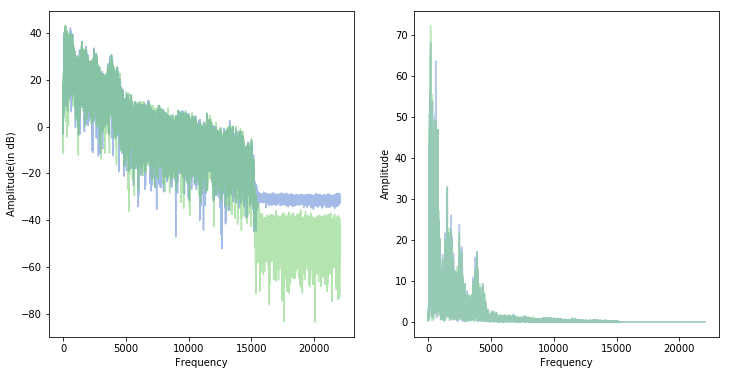

In [8]:
plotFrequencySpectrum(16)

# Dimentionality reduction: PCA

In [9]:
# a handy function for vizualizing principle components as a heatmap
# this allows you to see what dimensions in the 'original space' are
# active

def visualize_pca_comps_heatmap(plot, comps):
    heatmap = plot.pcolor(comps, cmap=plt.cm.Blues)
    
    x_lab = [i for i in range(comps.shape[1])]
    y_lab = [i for i in (range(comps.shape[0]))]
    
    plot.set_xticks(np.arange(comps.shape[1])+0.5, minor=False)
    plot.set_yticks(np.arange(comps.shape[0])+0.5, minor=False)
    
    # want a more natural, table-like display
    plot.invert_yaxis()
    
    plot.set_xticklabels(x_lab, minor=False)
    plot.set_yticklabels(y_lab, minor=False)
    
    plt.title('Heatmap of PCA components Rows: components, Cols: Original dimensions')

In [10]:
print (F.shape)
F2 = F.reshape(F.shape[0],-1)
print (F2.shape)

(636L, 2L, 22050L)
(636L, 44100L)


Explained variance ratio: 
[ 0.21594287  0.07388996  0.04165431  0.02292928  0.02163418  0.01612717
  0.01581625  0.01167246  0.01101121  0.01042783  0.00893607  0.00836728
  0.00682303  0.0064175   0.00626836  0.00559451  0.00527889  0.00504065
  0.00463891  0.0045962 ]
Explained variance ratio: 
(20L,)
Cumulative explained variance: 
[ 0.21594287  0.28983283  0.33148714  0.35441642  0.3760506   0.39217777
  0.40799402  0.41966649  0.4306777   0.44110552  0.4500416   0.45840888
  0.4652319   0.4716494   0.47791777  0.48351227  0.48879117  0.49383182
  0.49847073  0.50306693]
PCA components: 
(20L, 44100L)
Wall time: 1.35 s


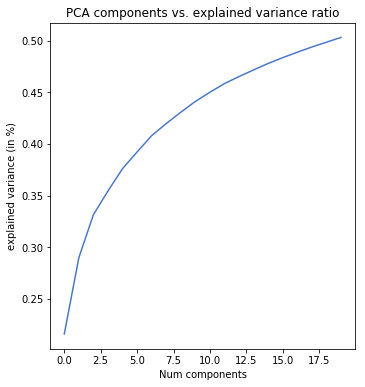

In [11]:
%%time
n_components = 20
model = PCA(n_components)
model.fit(F2)

print 'Explained variance ratio: \n', model.explained_variance_ratio_[-20:]
print 'Explained variance ratio: \n', model.explained_variance_ratio_.shape
print 'Cumulative explained variance: \n', np.cumsum(model.explained_variance_ratio_)[-20:]
print 'PCA components: \n', model.components_.shape

plt.figure(figsize=(12, 6))
#p2 = plt.subplot(1, 2, 1)
#visualize_pca_comps_heatmap(p2, model.components_)
plt.subplot(1, 2, 2)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('Num components')
plt.ylabel('explained variance (in %)')
plt.title('PCA components vs. explained variance ratio')

In [12]:
# Apply PCA Transformation to the input to create embeddings

In [13]:
%%time
print F2.shape
t= model.transform(F2)
print t.shape

(636L, 44100L)
(636L, 20L)
Wall time: 194 ms


In [18]:
%%time
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=900, learning_rate=20)
tsne_results = tsne.fit_transform(t)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 636 samples in 0.000s...
[t-SNE] Computed neighbors for 636 samples in 0.020s...
[t-SNE] Computed conditional probabilities for sample 636 / 636
[t-SNE] Mean sigma: 183.511580
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.791328
[t-SNE] Error after 900 iterations: 0.883481
Wall time: 13.1 s


In [21]:
df_tsne = pd.DataFrame(tsne_results[:,0], columns=["x-tsne"])
df_tsne["y-tsne"] = tsne_results[:,1]
df_tsne["labels"] = labels

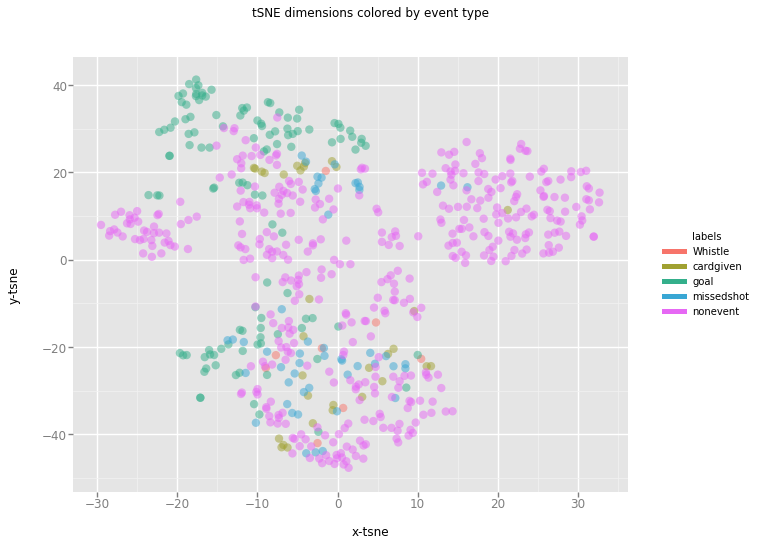

<ggplot: (25095537)>

In [22]:
chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='labels') ) \
        + geom_point(size=70,alpha=0.5) \
        + ggtitle("tSNE dimensions colored by event type")
chart

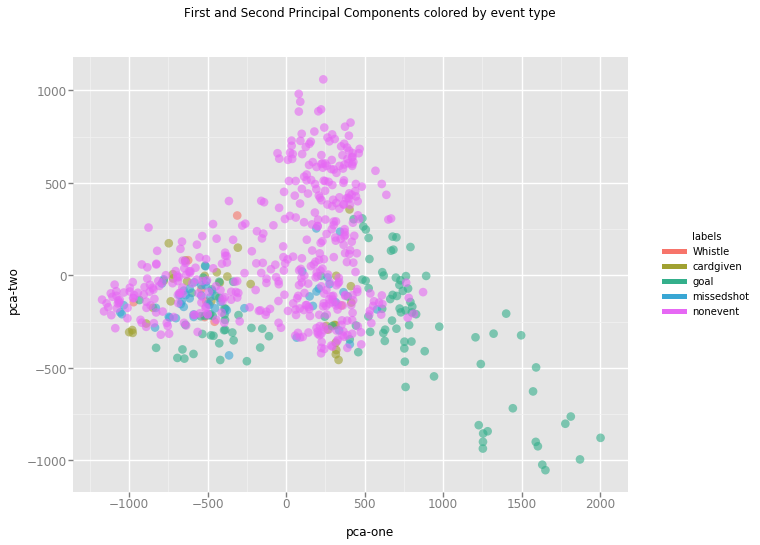

<ggplot: (54469492)>

In [23]:
df_pca = pd.DataFrame(t[:,0], columns=["pca-one"])
df_pca["pca-two"] = t[:,1]
df_pca["labels"] = labels


chart = ggplot( df_pca, aes(x='pca-one', y='pca-two', color='labels') ) \
        + geom_point(size=75,alpha=0.6) \
        + ggtitle("First and Second Principal Components colored by event type")
chart

In [24]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=n_components, n_iter=7, random_state=42)
svd_results = svd.fit_transform(F2)
print(svd.explained_variance_ratio_) 
print(svd.explained_variance_ratio_.sum()) 

[ 0.20261344  0.08046387  0.04353092  0.02443757  0.02163534  0.01615155
  0.01601437  0.0117099   0.01160204  0.0104896   0.00912072  0.00867003
  0.0068464   0.0065131   0.00628936  0.00562488  0.00539956  0.00517803
  0.00492841  0.00461167]
0.501830766267


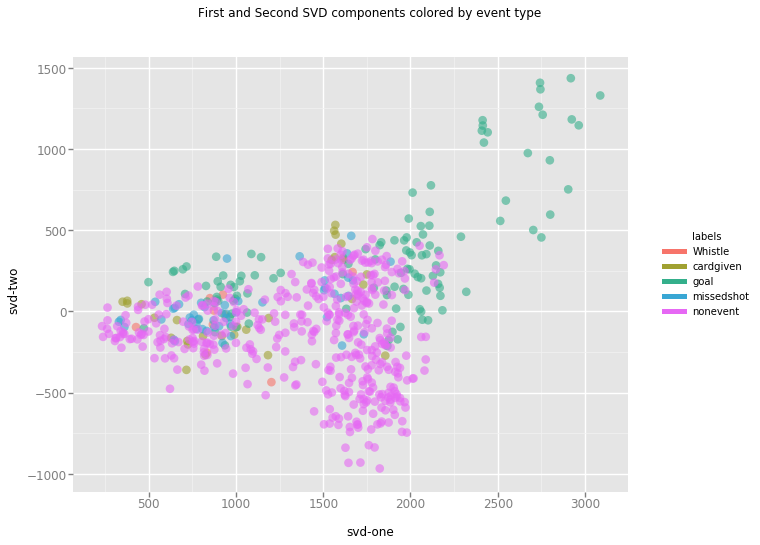

<ggplot: (54442942)>

In [25]:
df_svd = pd.DataFrame(svd_results[:,0], columns=["svd-one"])
df_svd["svd-two"] = svd_results[:,1]
df_svd["labels"] = labels


chart = ggplot( df_svd, aes(x='svd-one', y='svd-two', color='labels') ) \
        + geom_point(size=75,alpha=0.6) \
        + ggtitle("First and Second SVD components colored by event type")
chart

# Classifiers

## Prepare training and test Data Sets

In [52]:
from sklearn.model_selection import train_test_split
data_train, data_test, labels_train, labels_test = train_test_split(F2, labels, test_size=0.20, random_state=42)

## Utilities

In [53]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


## KNN Classifier

In [57]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

model = KNeighborsClassifier(n_neighbors=1)
model.fit(data_train, labels_train)
test_predicted_labels = model.predict(data_test)

wrong_prediction = (test_predicted_labels != labels_test)

print 'number of incorrect predictions:', np.sum(wrong_prediction)
print 'accuracy:', np.sum(wrong_prediction)/len(labels_test)

number of incorrect predictions: 35
accuracy: 0


In [58]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print 'accuracy: {0:.3g}%'.format(100*float(np.sum((test_predicted_labels == labels_test)))/len(labels_test))
print("F1 score: {0:.3g}%".format(100*f1_score(labels_test, test_predicted_labels, average="macro")))
print("Precision: {0:.3g}%".format(100*precision_score(labels_test, test_predicted_labels, average="macro")))
print("Recall: : {0:.3g}%".format(100*recall_score(labels_test, test_predicted_labels, average="macro")))   

accuracy: 72.7%
F1 score: 42.6%
Precision: 48.2%
Recall: : 43%


Confusion matrix, without normalization
[[ 0  0  0  1  1]
 [ 0  2  0  0  2]
 [ 0  2 10  5 13]
 [ 0  0  0  4  7]
 [ 0  1  1  2 77]]


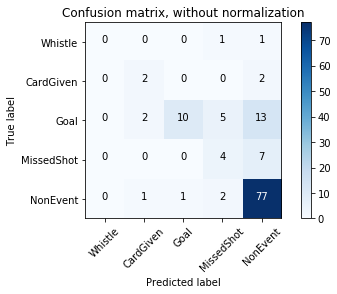

In [59]:
cnf_matrix = confusion_matrix(labels_test, test_predicted_labels)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Whistle","CardGiven","Goal","MissedShot","NonEvent"],
                      title='Confusion matrix, without normalization')